In [ ]:

from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd MyDrive/chest_xray/

/content/gdrive/MyDrive/chest_xray


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [73]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
HEIGHT = 32
WIDTH = 32

TRAIN_DIR = "train"

test_DIR = "test"

BATCH_SIZE = 64

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)

test_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
        )

test_generator = test_datagen.flow_from_directory(test_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)

Found 1350 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [76]:
img, labels = next(train_generator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


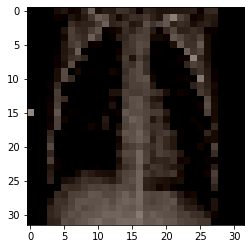

In [77]:

plt.imshow(img[0]/255.0)
plt.show()

In [75]:
X_train, Y_train = next(train_generator)

In [78]:
X_test, Y_test = next(test_generator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

x_train shape: (64, 32, 32, 3) - y_train shape: (64, 2)
x_test shape: (64, 32, 32, 3) - y_test shape: (64, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

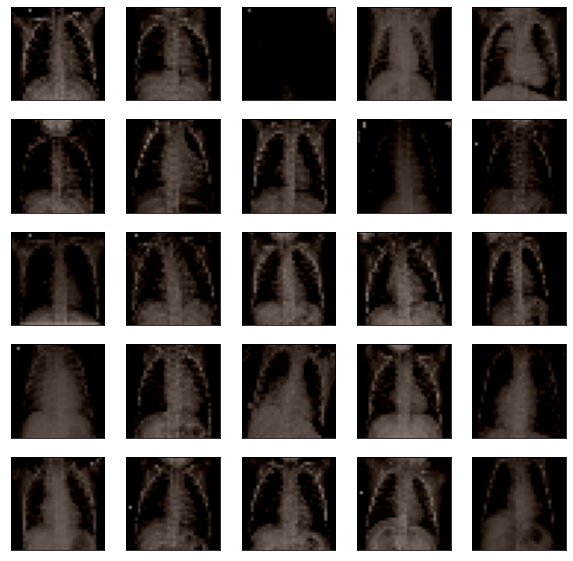

In [79]:
num_classes = 2
input_shape = (32, 32,3)
X_train, X_test = X_train / 255.0, X_test / 255.0
y_train = keras.utils.to_categorical(Y_train, num_classes)
y_test = keras.utils.to_categorical(Y_test, num_classes)
print(f"x_train shape: {X_train.shape} - y_train shape: {Y_train.shape}")
print(f"x_test shape: {X_test.shape} - y_test shape: {Y_test.shape}")

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
plt.show()

In [80]:
num_classes = 2
input_shape = (32, 32,3)
patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 32  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 128
num_epochs = 40
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

In [81]:

def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output


In [82]:

class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super(WindowAttention, self).__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv


In [83]:

class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super(SwinTransformer, self).__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x


In [84]:

class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super(PatchMerging, self).__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)


In [85]:
input = layers.Input(input_shape)
x = layers.RandomCrop(image_dimension, image_dimension)(input)
x = layers.RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

In [116]:
model = keras.Model(input, output)
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
   metrics=[METRICS]
)

history = model.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(X_test,Y_test))

Epoch 1/40
1/1 [==============================] - 8s 8s/step - loss: 0.2737 - tp: 61.0000 - fp: 3.0000 - tn: 61.0000 - fn: 3.0000 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9956 - val_loss: 0.6652 - val_tp: 43.0000 - val_fp: 21.0000 - val_tn: 43.0000 - val_fn: 21.0000 - val_accuracy: 0.6719 - val_precision: 0.6719 - val_recall: 0.6719 - val_auc: 0.7626
Epoch 2/40
1/1 [==============================] - 1s 1s/step - loss: 0.5525 - tp: 50.0000 - fp: 14.0000 - tn: 50.0000 - fn: 14.0000 - accuracy: 0.7812 - precision: 0.7812 - recall: 0.7812 - auc: 0.8940 - val_loss: 0.7028 - val_tp: 45.0000 - val_fp: 19.0000 - val_tn: 45.0000 - val_fn: 19.0000 - val_accuracy: 0.7031 - val_precision: 0.7031 - val_recall: 0.7031 - val_auc: 0.8376
Epoch 3/40
1/1 [==============================] - 1s 1s/step - loss: 0.4053 - tp: 54.0000 - fp: 10.0000 - tn: 54.0000 - fn: 10.0000 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9563 - val_loss: 0.6640 - val_tp: 49.0000 - val

In [117]:
acc = history.history['accuracy']
loss = history.history['loss']
auc = history.history['auc']
precision = history.history['precision']
recall = history.history['recall']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_auc = history.history['val_auc']
val_precision = history.history['val_precision']
val_recall = history.history['val_recall']

In [118]:
print("Metric Values after Training Next 28 Epochs : \n")
print('Train Accuracy : ', acc)
print('Train Loss : ', loss)
print('Train AUC : ', auc)
print('Train Precision : ', precision)
print('Train Recall : ', recall)
print('Train Val_Accuracy : ', val_acc)
print('Train Val_Loss : ', val_loss)
print('Train Val_Auc : ', val_auc)
print('Train Val_Precision : ', val_precision)
print('Train Val_Recall : ', val_recall)
print("==========================================")

Metric Values after Training Next 28 Epochs : 

Train Accuracy :  [0.953125, 0.78125, 0.84375, 0.9375, 0.984375, 0.921875, 0.875, 0.953125, 0.984375, 0.921875, 0.984375, 0.96875, 1.0, 0.96875, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 0.96875, 1.0, 0.96875, 0.953125, 1.0, 1.0, 1.0, 1.0]
Train Loss :  [0.27365827560424805, 0.5524955987930298, 0.40529489517211914, 0.33079081773757935, 0.2788239121437073, 0.36358416080474854, 0.3551573157310486, 0.28546983003616333, 0.2453342080116272, 0.2937607169151306, 0.2986898720264435, 0.2792145907878876, 0.24457448720932007, 0.2569977641105652, 0.27759653329849243, 0.27458277344703674, 0.23286792635917664, 0.23176398873329163, 0.2294994741678238, 0.24623894691467285, 0.2294001579284668, 0.24730587005615234, 0.2230912744998932, 0.2290412336587906, 0.2344955950975418, 0.22771362960338593, 0.2306806892156601, 0.23806080222129822, 0.24882088601589203, 0.224130585789

In [119]:
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix,precision_recall_curve,average_precision_score,accuracy_score

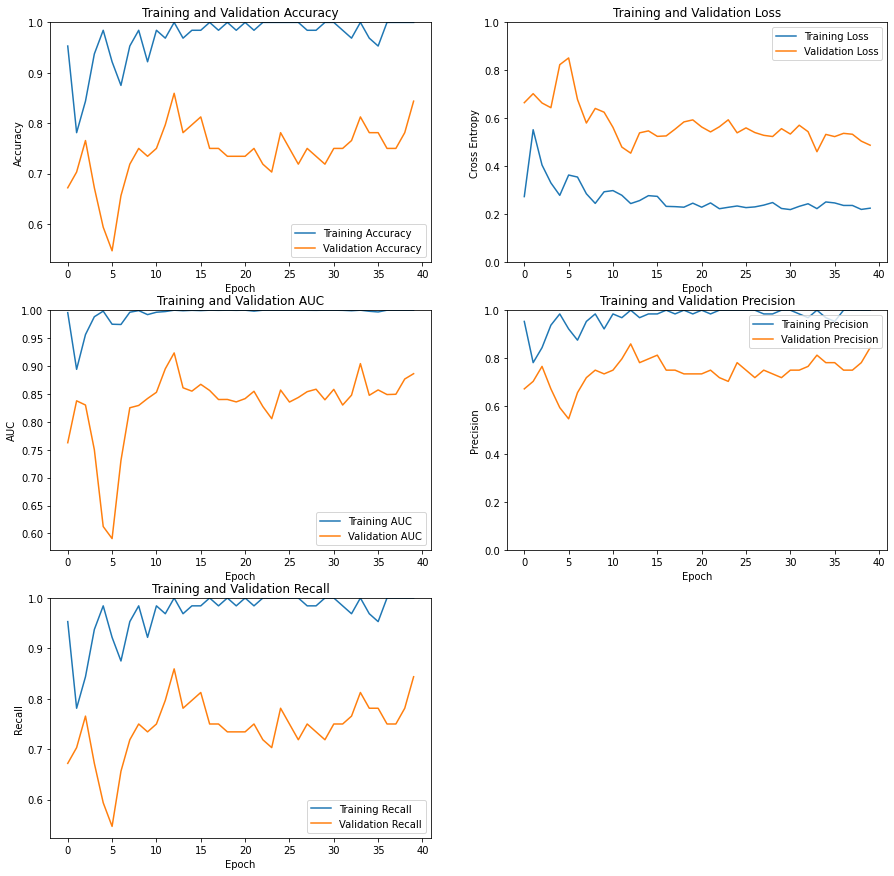

In [120]:
#Plotting the metrics:

plt.figure(figsize=(15, 15))

#Plotting the Accuracy:
plt.subplot(3, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')

#Plotting the Loss:
plt.subplot(3, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

#Plotting the AUC:
plt.subplot(3, 2, 3)
plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.ylabel('AUC')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')

#Plotting the Precision:
plt.subplot(3, 2, 4)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend(loc='upper right')
plt.ylabel('Precision')
plt.ylim([0,1.0])
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')

#Plotting the Recall:
plt.subplot(3, 2, 5)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Recall')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')

#Showing all the graphs:
plt.show()

In [103]:
HEIGHT = 32
WIDTH = 32

val_DIR = "val"


BATCH_SIZE = 64

val_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      
    )

val_generator = val_datagen.flow_from_directory(val_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)

Found 16 images belonging to 2 classes.


In [104]:
X_val, Y_val = next(val_generator)


In [108]:
num_classes = 2
input_shape = (32, 32,3)
X_val= X_val / 255.0
y_val = keras.utils.to_categorical(Y_val, num_classes)

In [141]:
#Evaluating on the validation set
Evaluate = model.evaluate(X_test,Y_test)

2/2 [==============================] - 0s 207ms/step - loss: 0.4893 - tp: 52.0000 - fp: 12.0000 - tn: 52.0000 - fn: 12.0000 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8855


In [159]:
valid_predictions_baseline = model.predict(X_test)

In [142]:
val_precision = round((Evaluate[6]),5)
val_recall = round((Evaluate[7]),5)
val_loss = round((Evaluate[0]),5)
val_auc = round((Evaluate[8]),5)
print('METRIC VALUES FOR VALIDATE DATASET')
print('PRECISION : ', val_precision)
print('RECALL : ', val_recall)
print('LOSS : ', val_loss)
print('AUC : ', val_auc)

METRIC VALUES FOR VALIDATE DATASET
PRECISION :  0.8125
RECALL :  0.8125
LOSS :  0.48934
AUC :  0.8855


In [143]:
def plot_roc(name, labels, predictions):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
  auc = round(metrics.auc(fp, tp),3)
  
  plt.figure(figsize=(8, 8))
  plt.plot(100*fp, 100*tp, label=name+" = " +str(auc), linewidth=2)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.grid(True)
  plt.title("ROC Curve")
  ax = plt.gca()
  ax.set_aspect('equal')

In [160]:
prediction = valid_predictions_baseline.reshape(-1)
Y_test = Y_test.reshape(-1)

array([0.01501074, 0.9849893 , 0.01512289, 0.9848771 , 0.01549772,
       0.98450226, 0.01511669, 0.98488337, 0.01497859, 0.9850214 ,
       0.0155711 , 0.9844289 , 0.01523862, 0.98476136, 0.01523511,
       0.9847648 , 0.01529029, 0.9847097 , 0.01479704, 0.98520297,
       0.70595455, 0.29404548, 0.01547295, 0.9845271 , 0.11804321,
       0.88195676, 0.01487754, 0.98512244, 0.01522944, 0.9847705 ,
       0.01539148, 0.9846086 ], dtype=float32)

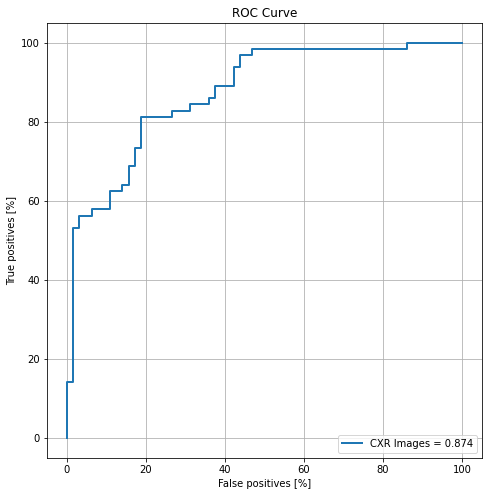

In [161]:
#Plotting the ROC Curve on CXR Dataset:
plot_roc("CXR Images",Y_test , prediction)
plt.legend(loc='lower right')

In [162]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  tn = cm[0][0]
  fn = cm[1][0]
  fp = cm[0][1]
  tp = cm[1][1]

  sensitivity = round((tp/(tp+fn)),3)
  specificity = round((tn/(tn+fp)),3)
  accuracy = round(((tp + tn)/(tp+tn+fp+fn)),3)
  PPV = round((tp/(tp + fp)),3)
  NPV = round((tn/(tn + fn)),3)
  print('Total Records Detected : ', labels.shape[0])
  print('Total Pneumothorax Cases : ', np.sum(cm[1]))
  print("=====================================")
  print('True Negatives : ', tn)
  print('False Positives : ', fp)
  print('False Negatives : ', fn)
  print('True Positives : ', tp)
  print("=====================================")
  print('Accuracy : ', accuracy)
  print('PPV : ', PPV)
  print('NPV : ', NPV)
  print('Sensitivity : ', sensitivity)
  print('Specificity : ', specificity)
  print("=====================================")

  return tn,fn,fp,tp,sensitivity,specificity,accuracy,PPV,NPV

In [166]:
predictions

[0.4945688843727112,
 52.0,
 12.0,
 52.0,
 12.0,
 0.8125,
 0.8125,
 0.8125,
 0.87939453125]

Total Records Detected :  128
Total Pneumothorax Cases :  64
True Negatives :  52
False Positives :  12
False Negatives :  12
True Positives :  52
Accuracy :  0.812
PPV :  0.812
NPV :  0.812
Sensitivity :  0.812
Specificity :  0.812


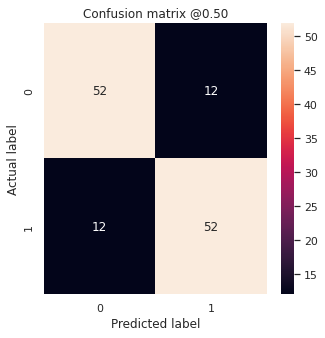

In [168]:
import seaborn as sns; sns.set_theme()

tn,fn,fp,tp,sensitivity,specificity,accuracy,PPV,NPV = plot_cm(Y_test, prediction)

In [169]:
def plot_precision_recall_curve(name, labels, predictions):
  
  class_precision, class_recall, _ = precision_recall_curve(labels, predictions)
  average_precision = round((average_precision_score(labels, predictions)),3)

  plt.figure(figsize=(8, 8))
  plt.plot(100*class_recall, 100*class_precision, label=name +" = "+ str(average_precision), linewidth=2)
  plt.xlabel('Recall [%]')
  plt.ylabel('Precision [%]')
  #plt.xlim([-0.5,20])
  #plt.ylim([80,100.5])
  plt.grid(True)
  plt.legend()
  plt.title("Precision-Recalll Curve")
  ax = plt.gca()
  ax.set_aspect('equal')

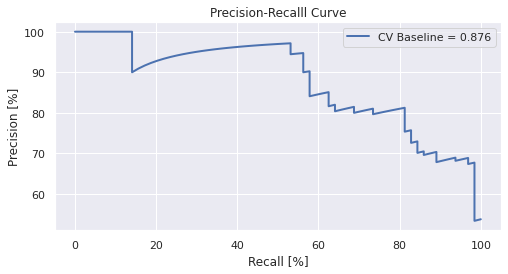

In [170]:
plot_precision_recall_curve("CV Baseline", Y_test, prediction)

In [172]:
saved_loss = round((Evaluate[0]),5)

In [174]:
import pandas as pd
data = [{'Values' : accuracy}, {'Values' : val_precision}, {'Values' : val_recall}, {'Values' : sensitivity}, 
        {'Values' : specificity}, {'Values' : PPV}, {'Values' : NPV}, {'Values' : saved_loss}]

labels = ['Accuracy', 'Precision', 'Recall','Sensitivity (Recall)', 'Specificity', 'PPV (Precision)', 'NPV', 'LOSS']
classification_metricValues_df = pd.DataFrame(data, index =labels) 

In [175]:
classification_metricValues_df

,Values
Accuracy,0.81200
Precision,0.81250
Recall,0.81250
Sensitivity (Recall),0.81200
Specificity,0.81200
PPV (Precision),0.81200
NPV,0.81200
LOSS,0.48934
